In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
!pip install strawberryfields matplotlib
%matplotlib inline

  Using cached StrawberryFields-0.23.0-py3-none-any.whl.metadata (7.6 kB)
  Using cached networkx-3.2.1-py3-none-any.whl.metadata (5.2 kB)
  Using cached numpy-2.0.2-cp39-cp39-win_amd64.whl.metadata (59 kB)
  Using cached quantum_blackbird-0.5.0-py3-none-any.whl.metadata (4.6 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached scipy-1.13.1-cp39-cp39-win_amd64.whl.metadata (60 kB)
  Using cached sympy-1.13.3-py3-none-any.whl.metadata (12 kB)
  Using cached thewalrus-0.21.0-py3-none-any.whl.metadata (6.2 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl.metadata (7.1 kB)
  Using cached urllib3-2.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached quantum_xir-0.2.2-py3-none-any.whl.metadata (4.1 kB)
  Using cached xanadu_cloud_client-0.3.2-py3-none-any.whl.metadata (8.3 kB)
  Using cached contourpy-1.3.0-cp39-cp39-win_amd64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.7-cp39-cp39-wi


An introduction to the bosonic backend
======================================

<div class="alert alert-info"><h4>Note</h4><p>This tutorial is first in a series on the ``bosonic`` backend. After getting acquainted
   with the backend in this tutorial, go to :doc:`part 2 </demos/run_sampling_bosonic>`
   to learn about how the backend can be used to sample non-Gaussian states. After that,
   check out :doc:`part 3 </demos/run_GKP_bosonic>` for a deep dive into using the ``bosonic``
   backend to simulate qubits encoded in photonic modes. These tutorials accompany
   our research paper [[#bourassa2021]_].</p></div>

So far, Strawberry Fields allows its users to simulate photonic circuits using three
backends. Two of them, the ``fock`` and ``tf`` backends, represent the quantum state of the modes using the Fock or particle basis. These backends allow one to represent
arbitrary quantum states up to a photon cutoff, but this generality comes with an automatic
exponential increase in the space complexity as a function of the number of modes
with the base of the exponent scaling as the energy of the state of light.
At the exact opposite end of this trade-off is the ``gaussian`` backend, in which there is no
exponential scaling in the memory required, but at the same time there is only a subset of states
that can be represented.

In this tutorial, we introduce the new ``bosonic`` backend which borrows some of the best features
of all the previous backends. Specifically, the ``bosonic`` backend is tailored to simulate states
which can be represented as a linear combination of Gaussian functions in phase space.
It provides very succinct descriptions of Gaussian states, just
like the ``gaussian`` backend, but it can also provide descriptions of non-Gaussian states as well.
Moreover, like in the ``gaussian`` backend, the application of the most common active and passive linear
optical operations, like the displacement ``Dgate``, squeezing ``Sgate`` and beamsplitter ``BSgate`` gates,
is extremely efficient.

To motivate the ideas behind the backend, we will investigate how to represent the highly non-classical
and non-Gaussian cat state. Once we build our intuition we will introduce the ``bosonic`` backend and
investigate how it represents quantum states. Finally, we discuss why
it can provide advantages over other backends for many applications.

<div class="alert alert-info"><h4>Note</h4><p>We assume the reader is familiar with the basics of the phase-space picture of quantum mechanics,
   including Wigner functions. For the uninitiated, a good place to start is the :doc:`CV quantum gate visualizations
   tutorial </demos/run_gate_visualization>`.</p></div>


Of Cats and Kets
----------------

Cat states are defined to be linear superpositions of two coherent states

\begin{align}|k^\alpha \rangle_{\text{cat}} = \sqrt{\mathcal{N}}\left(|\alpha \rangle + e^{i \pi k} |-\alpha \rangle \right),\end{align}

where $| \alpha \rangle$ is a coherent state with amplitude
$\alpha$, $k$ is the phase parameter of the cat state and

\begin{align}\mathcal{N} = \frac{1}{2 (1+e^{-|\alpha|^2}\cos(\pi k) )}\end{align}

is a normalization constant.

Given the universality of the Fock backend we can use it to simulate the preparation of this state
and plot its Wigner function:



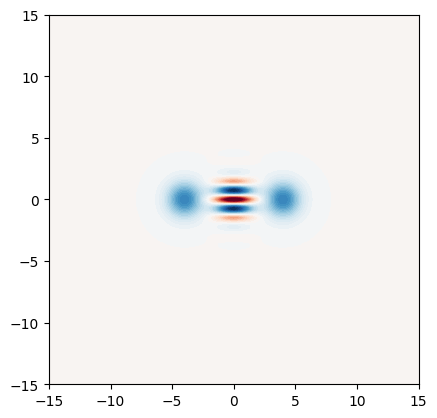

In [2]:
# Usual imports
import strawberryfields as sf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

# Simulation and cat state parameters
nmodes = 1
cutoff = 30
q = 4.0
p = 0.0
hbar = 2
alpha = (q + 1j * p) / np.sqrt(2 * hbar)
k = 1

# SF program
prog_cat_fock = sf.Program(nmodes)
with prog_cat_fock.context as q:
    sf.ops.Catstate(a=np.absolute(alpha), phi=np.angle(alpha), p=k) | q

eng = sf.Engine("fock", backend_options={"cutoff_dim": cutoff, "hbar": hbar})
state = eng.run(prog_cat_fock).state

# We now plot it
xvec = np.linspace(-15, 15, 401)
W = state.wigner(mode=0, xvec=xvec, pvec=xvec)
Wp = np.round(W.real, 4)
scale = np.max(Wp.real)
nrm = mpl.colors.Normalize(-scale, scale)
plt.axes().set_aspect("equal")
plt.contourf(xvec, xvec, Wp, 60, cmap=cm.RdBu, norm=nrm)
plt.show()

Some parts of the Wigner function are easy to interpret: since the state
is a coherent superposition of two widely separated coherent states,
we expect to see two circular blobs centered around $(q,p)=\pm\sqrt{2 \hbar}(\Re(\alpha), \Im(\alpha))$.
Because a cat state is a *coherent* superposition of the two coherent states,
we also see interference fringes in between the "classical" states of the cat.
Mathematically, one can determine the nature of these interference fringes by
looking at the density matrix of a cat state given by

\begin{align}|k^\alpha \rangle \langle k^\alpha |_{\text{cat}} = \mathcal{N} \left( |\alpha \rangle \langle \alpha| + |-\alpha \rangle \langle -\alpha|+e^{i \pi k} |-\alpha \rangle \langle \alpha | + e^{-i \pi k} |\alpha \rangle \langle -\alpha |\right).\end{align}

The transformation from density matrix to Wigner function is linear, so the first two terms exactly correspond to the Wigner functions of the two coherent states
$|\pm \alpha \rangle$ and are thus Gaussian functions centered around $\boldsymbol{\mu} = \sqrt{2 \hbar}(\Re(\alpha), \Im(\alpha))$,
with the usual vacuum noise giving them some finite width.
The last two terms in the equation above are more complicated to interpret. We know that they are the Hermitian
conjugates of each other $(\left[ e^{i \pi k} |-\alpha \rangle \langle \alpha |\right]^\dagger = e^{-i \pi k} |\alpha \rangle \langle -\alpha |)$
, and by elimination they must correspond to the interference features present close to the origin
of phase space.

In our recent preprint [[#bourassa2021]_], we show that the Wigner function of terms like $|-\alpha \rangle \langle \alpha |$
is also a Gaussian function, but with *complex* means $\boldsymbol{\mu} = \sqrt{2 \hbar} i (\Im(\alpha),-\Re(\alpha))$.
Therefore, we can express the Wigner function of the cat state as a weighted sum of four Gaussians in phase space ---
as long as we allow the Gaussians to have complex means.
Since a cat state can be written as a linear combination of Gaussian functions in phase space, we can simulate
the same circuit presented above using the ``bosonic`` backend. Since this backend does not
use Fock states, we don't need to pass a cutoff argument, thus we can write:



In [3]:
prog_cat_bosonic = sf.Program(nmodes)

with prog_cat_bosonic.context as q:
    sf.ops.Catstate(a=np.absolute(alpha), phi=np.angle(alpha), p=k) | q

eng = sf.Engine("bosonic", backend_options={"hbar": hbar})
state = eng.run(prog_cat_bosonic).state

We can now inspect the internal representation of the cat state inside
the ``bosonic`` backend. To this end, we can print the attributes ``means``,
``covs`` and ``weights``.
The ``means`` variable is a NumPy array containing the means of the
four Gaussians needed to describe the state.



In [4]:
means = state.means()
print(means)

[[ 4.+0.j  0.+0.j]
 [-4.+0.j -0.+0.j]
 [ 0.+0.j  0.-4.j]
 [ 0.+0.j  0.+4.j]]


The first axis of the array is the one labelling the different Gaussians.
Similarly, ``covs`` contains the covariance matrices of the four Gaussians:



In [5]:
covs = state.covs()
print(covs)

[[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]


Finally, as noted earlier the Wigner function is a *weighted* sum of the
four different Gaussians, the actual ``weights`` or coefficients are given by



In [6]:
weights = state.weights()
print(weights)

[ 5.00167788e-01+0.00000000e+00j  5.00167788e-01+0.00000000e+00j
 -1.67787600e-04-2.05480548e-20j -1.67787600e-04+2.05480548e-20j]


Note that both the ``weights`` and ``means`` are complex.
With the information provided from the backend, we are ready to verify
that we got the correct cat. To this end, we will first create a simple
wrapper function to generate a Gaussian with mean ``mu`` and covariance
matrix ``V`` and a convenience function to evaluate it on a grid of points:



In [7]:
def gaussian_func_gen(mu, V):
    """Generates a function that when evaluated returns
    the value of a normalized Gaussian specified in terms
    of a vector of means and a covariance matrix.

    Args:
        mu (array): vector of means
        V (array): covariance matrix

    Returns:
        (callable): a normalized Gaussian function
    """
    Vi = np.linalg.inv(V)
    norm = 1.0 / np.sqrt(np.linalg.det(2 * np.pi * V))
    fun = lambda x: norm * np.exp(-0.5 * (x - mu) @ Vi @ (x - mu))
    return fun


def evaluate_fun(fun, xvec, yvec):
    """Evaluate a function a 2D in a grid of points.

    Args:
        fun (callable): function to evaluate
        xvec (array): values of the first variable of the function
        yvec (array): values of the second variable of the function

    Returns:
        (array): value of the function in the grid
    """
    return np.array([[fun(np.array([x, y])) for x in xvec] for y in xvec])


funs = [gaussian_func_gen(means[i], covs[i]) for i in range(len(means))]

Wps = [weights[i] * evaluate_fun(funs[i], xvec, xvec) for i in range(len(weights))]

The list ``Wps`` contains the values of the different Gaussians making
the Wigner function of the cat state. We can easily verify that when we
sum the different components for every point in phase space we obtain
a zero imaginary part:



In [8]:
print(np.allclose(sum(Wps).imag, 0))

True


In fact, we can verify that the last two components are the complex
conjugate of each other (thus their sum is real),
and that the first two components are strictly real:



In [9]:
print(np.allclose(Wps[2],  Wps[3].conj()))
print(np.allclose(Wps[0].imag, 0))
print(np.allclose(Wps[1].imag, 0))

True
True
True


We can look individually at each of the Gaussians as well:



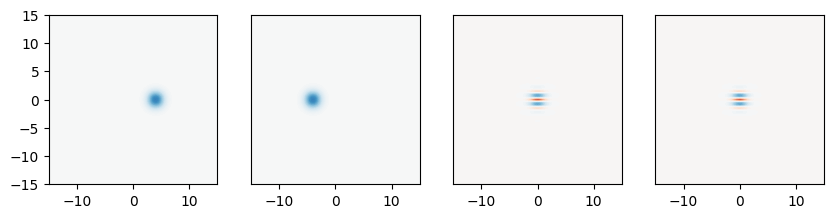

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(10, 2.2))
for i in range(4):
    Wp = np.round(Wps[i].real, 4)
    axs[i].contourf(xvec, xvec, Wp, 60, cmap=cm.RdBu, norm=nrm)
    if i != 0:
        axs[i].set_yticks([])
plt.show()

And also put them together to obtain exactly the same Wigner function
from before:



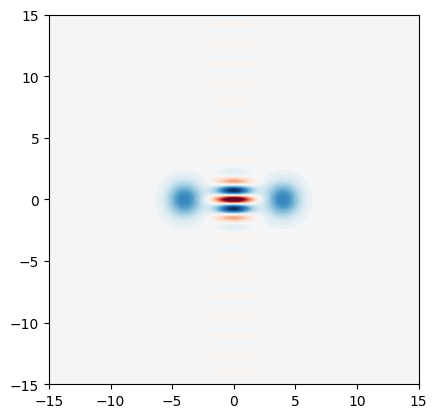

In [11]:
Wcat = sum(Wps)
plt.axes().set_aspect("equal")
plt.contourf(xvec, xvec, Wcat.real, 60, cmap=cm.RdBu, norm=nrm)
plt.show()

Why is the bosonic backend useful?
----------------------------------
Now that we understand the internal workings of the new ``bosonic``
backend, let's illustrate its utility. To this end, let us consider
a slightly more complicated circuit where we displace a cat state.
This is how it looks in the Fock backend:



In [12]:
x = 6
y = 0

beta = (x + 1j * y) / np.sqrt(2 * hbar)
prog_cat_fock_displaced = sf.Program(nmodes)

with prog_cat_fock_displaced.context as q:
    sf.ops.Catstate(a=np.absolute(alpha), phi=np.angle(alpha), p=k) | q
    sf.ops.Dgate(beta) | q

eng = sf.Engine("fock", backend_options={"cutoff_dim": cutoff, "hbar": hbar})
state = eng.run(prog_cat_fock_displaced).state

Plotting the Wigner function of the returned state:



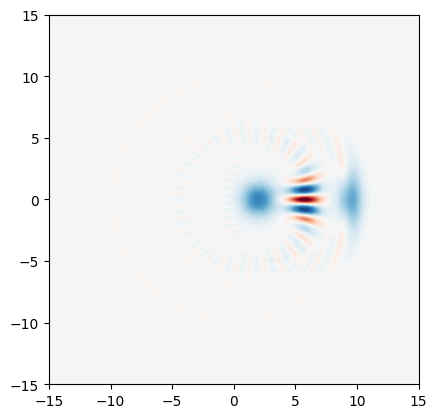

In [13]:
W = state.wigner(mode=0, xvec=xvec, pvec=xvec)
plt.axes().set_aspect("equal")
plt.contourf(xvec, xvec, W, 60, cmap=cm.RdBu, norm=nrm)
plt.show()

This plot does not meet our expectation that a ``Dgate`` gate simply
displaces the Wigner function of a state. Indeed, we see that significant distortion occurs in the
right-hand-side .
This happened because the ``cutoff`` we choose is not sufficient to faithfully
represent the *displaced* cat. A simple solution to this problem is to increase
the ``cutoff`` in the simulation, but that will lead to an increase in memory and
a slower simulation.
The behaviour of the ``fock`` backend can be contrasted
with the one of the ``bosonic`` backend where we obtain



In [14]:
prog_cat_bosonic_displaced = sf.Program(nmodes)

with prog_cat_bosonic_displaced.context as q:
    sf.ops.Catstate(a=np.absolute(alpha), phi=np.angle(alpha), p=k) | q
    sf.ops.Dgate(beta) | q

eng = sf.Engine("bosonic", backend_options={"hbar": hbar})
state = eng.run(prog_cat_bosonic_displaced).state

Just like in the case of the ``fock`` backend,
we can also use the ``wigner`` method to generate Wigner functions:



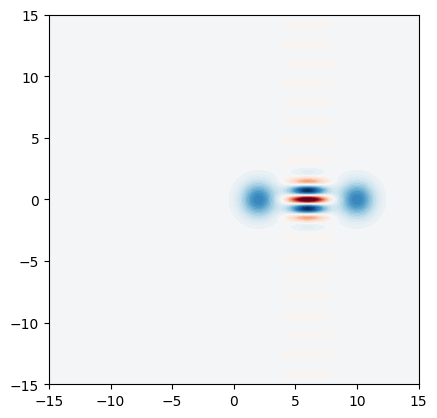

In [15]:
Wps = state.wigner(mode=0, xvec=xvec, pvec=xvec)
plt.axes().set_aspect("equal")
plt.contourf(xvec, xvec, Wps, 60, cmap=cm.RdBu, norm=nrm)
plt.show()

We can easily verify that in the internal representation in the backend
we have only modified the displacement relative to the first program
we investigated:



In [16]:
print(state.means())

[[10.+0.j  0.+0.j]
 [ 2.+0.j  0.+0.j]
 [ 6.+0.j  0.-4.j]
 [ 6.+0.j  0.+4.j]]


Conclusions and Outlook
-----------------------
In this tutorial, we have introduced the new ``bosonic`` backend of Strawberry Fields,
explained the basic idea of how it represents quantum states and
showcased some of the advantages it has with respect to other backends.
We observed that when the energy of the cat state being considered was
increased by displacement, the Fock backend gave unexpected results,
and it actually requires higher cutoff and more memory for accurate results.
On the other hand, the bosonic backend can quickly and easily deal with
situations such as this on by merely changing the means and covariance
matrices of the represented state.
For a more advanced feature, check out :doc:`part 2 </demos/run_sampling_bosonic>`
of this series to see how the bosonic backend can be used for sampling.




References
----------

.. [#bourassa2021]

    J. Eli Bourassa, Nicolás Quesada, Ilan Tzitrin, Antal Száva, Theodor Isacsson,
    Josh Izaac, Krishna Kumar Sabapathy, Guillaume Dauphinais, and Ish Dhand.
    Fast simulation of bosonic qubits via Gaussian functions in phase space.
    `arXiv:2103.05530 <https://arxiv.org/abs/2103.05530>`_, 2021.

